In [11]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


env = gym.make('CartPole-v1')

print(env.action_space)
print(env.observation_space)
print(env.spec.reward_threshold)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Discrete(2)
Box(4,)
475.0
cuda


**Actor Critic Network**

In [0]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.linear1 = nn.Linear(env.observation_space.shape[0], 128)
    self.dropout = nn.Dropout(p=0.6)
    self.head = nn.Linear(128, env.action_space.n)

  def forward(self, x):
    x = self.linear1(x)
    x = self.dropout(x)
    x = F.relu(x)
    return F.softmax(self.head(x), -1)


class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.linear1 = nn.Linear(env.observation_space.shape[0], 128)
    self.head = nn.Linear(128, 1)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    return self.head(x.view(x.size(0), -1))

**Advantage Actor Critic Agent**

In [0]:
class ACTOR_CRITIC_AGENT():
  def __init__(self):
    self.actor = Actor()
    self.critic = Critic()
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-2)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-2)
    self.gamma = 0.99
    self.rewards = []
    self.log_probs = []
    self.state_values = []



  #https://pytorch.org/docs/stable/distributions.html
  def select_action(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = self.actor(state)
    state_val = self.critic(state)
    m = Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    return action, log_prob, state_val #action, log_prob, state_value

  def truth(self):
    R = 0
    truth = []
    for r in self.rewards[::-1]:
        R = r + self.gamma * R
        truth.insert(0, R)
    truth = torch.tensor(truth)
    truth = (truth - truth.mean())
    return truth

  def optimize_model(self):
    actor_loss = []
    critic_loss = []
    truth = self.truth()
    # print(len(self.log_probs), len(self.rewards))
    for log_prob, value, R in zip(self.log_probs, self.state_values, truth):
        # calculate advantage
        advantage = R - value.item()
        # actor policy loss
        actor_loss.append(-log_prob * advantage)
        # Crtit loss
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([R]).unsqueeze(1)))


    # Actor loss backprop
    self.actor_optimizer.zero_grad()
    actor_loss = torch.cat(actor_loss).sum()
    actor_loss.backward()
    self.actor_optimizer.step()

    #Critic loss backprop
    self.critic_optimizer.zero_grad()
    critic_loss = torch.stack(critic_loss).sum()
    critic_loss.backward()
    self.critic_optimizer.step()
    
    #reset
    del self.rewards[:]
    del self.log_probs[:]
    del self.state_values[:]

  def train(self):
    running_reward = 10
    total_rewards = []
    mean_rewards = []
    # run till it solves
    for i_episode in count(1): #range(num_episodes):
      state = env.reset()
      r = 0
      for t in count():
        action, log_prob, state_val = self.select_action(state)
        self.log_probs.append(log_prob)
        self.state_values.append(state_val)
        next_state, reward, done, _ = env.step(action.item())
        self.rewards.append(reward)

        # reward = torch.tensor([reward], device=device)
        r += reward #reward.item()

        # Move to the next state
        state = next_state
        if done:
          self.optimize_model()
          break

      total_rewards.append(r)

      # Exponential moving average
      running_reward = 0.05 * r + (1 - 0.05) * running_reward

      # Mean rewards over last 100 episodes
      avg_rewards = np.mean(total_rewards[-100:])
      mean_rewards.append(avg_rewards)
      if i_episode % 10 == 0:
          print('Episode {}\tEpisode reward: {:.2f}\tExp moving avg: {:.2f}\tMean-100 episodes: {:.2f}'.format(i_episode, r, running_reward, avg_rewards))
      if avg_rewards > env.spec.reward_threshold:
          print("SOLVED! Running reward is now {} and ""the last episode runs to {} time steps!"" Mean rewards over last 100 episodes {}".format(running_reward, t, avg_rewards))
          break
    return total_rewards, mean_rewards
            


In [14]:
agent = ACTOR_CRITIC_AGENT()
total_rewards, mean_rewards = agent.train()

Episode 10	Episode reward: 37.00	Exp moving avg: 15.31	Mean-100 episodes: 22.90
Episode 20	Episode reward: 29.00	Exp moving avg: 20.00	Mean-100 episodes: 25.50
Episode 30	Episode reward: 126.00	Exp moving avg: 29.60	Mean-100 episodes: 31.00
Episode 40	Episode reward: 31.00	Exp moving avg: 35.53	Mean-100 episodes: 34.70
Episode 50	Episode reward: 62.00	Exp moving avg: 42.68	Mean-100 episodes: 38.02
Episode 60	Episode reward: 29.00	Exp moving avg: 43.43	Mean-100 episodes: 39.15
Episode 70	Episode reward: 56.00	Exp moving avg: 47.62	Mean-100 episodes: 41.26
Episode 80	Episode reward: 56.00	Exp moving avg: 48.64	Mean-100 episodes: 42.31
Episode 90	Episode reward: 88.00	Exp moving avg: 52.45	Mean-100 episodes: 43.83
Episode 100	Episode reward: 93.00	Exp moving avg: 62.22	Mean-100 episodes: 46.97
Episode 110	Episode reward: 130.00	Exp moving avg: 73.88	Mean-100 episodes: 53.51
Episode 120	Episode reward: 141.00	Exp moving avg: 109.35	Mean-100 episodes: 66.70
Episode 130	Episode reward: 78.00

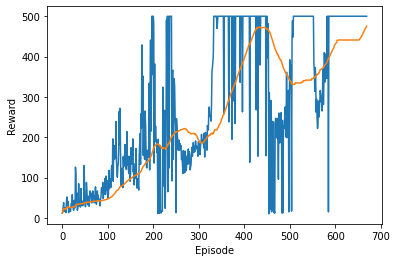

In [15]:
plt.plot(total_rewards)
plt.plot(mean_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()